In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from datetime import datetime

# PyTorch imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable


# Scikit-learn imports
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit


import chainladder as cl
import math
import random
import shap


# Local imports
from utils.config import ExperimentConfig, load_config_from_yaml
from utils.neural_networks import TabularNetRegressor, FeedForwardNet, ColumnKeeper, Make3D
from utils.data_engineering import load_data, process_data, create_train_test_datasets, process_data_davide, create_train_test_datasets_davide
from utils.tensorboard import generate_enhanced_tensorboard_outputs, create_actual_vs_expected_plot
from utils.excel import save_df_to_excel



In [2]:


# Load from YAML file
config = load_config_from_yaml('configs/NN_v_GBM_NJC_config.yaml')

# Set pandas display options
pd.options.display.float_format = '{:,.2f}'.format

type(config['data'])

SEED = config['training'].seed 
rng = np.random.default_rng(SEED) 
writer = SummaryWriter() 

# Create timestamp for output files
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"logs/log_NJC_NN_vs_GBM_outputs_{timestamp}.xlsx"

print(f"Experiment timestamp: {timestamp}")
print(f"Output file: {log_filename}")



Experiment timestamp: 20251012_174911
Output file: logs/log_NJC_NN_vs_GBM_outputs_20251012_174911.xlsx


In [3]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Data Loading and Processing
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Load data
dat_orig = load_data(config)

dat = process_data_davide(config, dat_orig)


In [4]:
data_cols = config['data'].data_cols
features = config['data'].features + ["backdate_periods"]


def backdate(df, backdate_periods, keep_cols):
    dedupe = [*set(["claim_no", "occurrence_period", "development_period", "payment_period"] + keep_cols)]
    bd = df.loc[:, dedupe].copy()
    bd["development_period"]= bd.development_period + backdate_periods
    bd.rename(columns={"payment_period": "payment_period_as_at"}, inplace=True)
    df= df[["claim_no", "occurrence_period", "development_period", "train_ind", "payment_size", "payment_period", "occurrence_time", "notidel"]].assign(
        data_as_at_development_period = lambda df: df.development_period - backdate_periods, 
        backdate_periods = backdate_periods
    ).merge(
        bd,
        how='left',
        on=["claim_no", "occurrence_period", "development_period"],
        suffixes=[None, "_backdatedrop"]
    )
    return df.drop(df.filter(regex='_backdatedrop').columns, axis=1)

num_dev_periods = config['data'].cutoff - 1

backdated_data = [backdate(dat, backdate_periods=i, keep_cols=data_cols) for i in range(0, num_dev_periods)]

extra_data = (
    dat.loc[dat.train_ind == 1, [*set(["claim_no", "occurrence_period", "development_period", "payment_period", "train_ind"] + data_cols)]]  # Training data
        .groupby("claim_no").last()  # Last training record per claim
        .rename(columns={"payment_period": "payment_period_as_at", "development_period": "data_as_at_development_period"})
        .assign(
            development_period = num_dev_periods + 1,  # set dev period to be tail
            payment_period = lambda df: df.occurrence_period + num_dev_periods + 1,
            backdate_periods = lambda df: num_dev_periods + 1 - df.payment_period,
            payment_size = 0
        )
        .reset_index()
)


all_data = pd.concat(backdated_data + [extra_data], axis="rows")

a = set(all_data.columns.to_list())
b = set(extra_data.columns.to_list())

assert list(b - a) == []
assert list(a - b) == []

nn_train_full = all_data.loc[all_data.train_ind == 1].loc[lambda df: ~np.isnan(df.payment_period_as_at)]        # Filter out invalid payment period as at
nn_test = all_data.loc[all_data.train_ind == 0].loc[lambda df: df.payment_period_as_at==(config['data'].cutoff + 1)].fillna(0)       # As at balance date
features = data_cols + ["backdate_periods"]

nn_train = nn_train_full.groupby(["claim_no", "development_period"]).sample(n=1, random_state=42)
nn_train.index.size == dat[dat.train_ind==1].index.size

nn_dat = pd.concat([nn_train.assign(train_ind=True), nn_test.assign(train_ind=False)])
# Run below instead to not use these ideas for now:
# nn_train = dat.loc[dat.train_ind == 1]
# nn_test = dat.loc[dat.train_ind == 0]



In [5]:
def claim_sampler(X, y):
    indices = torch.tensor(
        nn_train_full[["claim_no", "development_period", "data_as_at_development_period"]]
        .reset_index()
        .groupby(["claim_no", "development_period"])
        .sample(n=1)
        .index
    )
    return torch.index_select(X, 0, indices), torch.index_select(y, 0, indices)

use_batching_logic=True  # Set to False to omit this logic.

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CV Rolling origin
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

class RollingOriginSplit:
    def __init__(self, start_cut, n_splits):
        self.start_cut = start_cut
        self.n_splits = n_splits

    def split(self, X=None, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Payment period for splits
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        quantiles = pd.qcut(groups, self.start_cut + self.n_splits + 1, labels=False)

        for split_value in range(self.start_cut, self.start_cut + self.n_splits):
            yield np.where(quantiles <= split_value)[0], np.where(quantiles == split_value + 1)[0]

ps = RollingOriginSplit(5, 5).split(groups=dat.loc[dat.train_ind == 1].payment_period)
for tr, te in ps:
    print(len(tr), len(te), len(tr)+ len(te) )

40933 5685 46618
46618 9142 55760
55760 6543 62303
62303 6883 69186
69186 3571 72757


In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FFNN training
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
parameters_nn = {
    "l1_penalty": [0.0, 0.001, 0.01, 0.1],
    "weight_decay": [0.0, 0.001, 0.01, 0.1],
    "n_hidden": [5, 10, 20],
    # "interactions": [0.0, 0.25, 0.5, 0.75, 1.0],
    "dropout": [0, 0.25, 0.5],
    "max_iter": [config['training'].nn_cv_iter],
    "max_lr": [0.05],
    "verbose": [0],
    "clip_value": [None, 3.0],
    "keep_best_model": [True] 
}  

model_ffnn_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", RandomizedSearchCV(
            TabularNetRegressor(FeedForwardNet),
            parameters_nn,
            n_jobs=4,  # Run in parallel (small model)
            n_iter=config['training'].cv_runs, # Models train slowly, so try only a few models
            cv=RollingOriginSplit(5,5).split(groups=nn_train.payment_period),
            random_state=42
        )),
    ]
)

def set_seed(seed):
    """
    Imposta il seed per la riproducibilità in Python, NumPy e PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)

/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
trainx = nn_train.loc[:, config['data'].features + ["claim_no"]]
y_train = nn_train.loc[:, ["payment_size"]]

trainx


,notidel,occurrence_time,development_period,payment_period,has_payment_to_prior_period,log1_payment_to_prior_period,payment_count_to_prior_period,backdate_periods,claim_no
0,0.66,0.73,1,2,0.00,0.00,0.00,0,1
1,0.66,0.73,2,3,0.00,0.00,0.00,1,1
2,0.66,0.73,3,4,0.00,0.00,0.00,1,1
3,0.66,0.73,4,5,0.00,0.00,0.00,1,1
4,0.66,0.73,5,6,0.00,0.00,0.00,4,1
...,...,...,...,...,...,...,...,...,...
3568,0.06,39.54,40,80,0.00,0.00,0.00,-40,3659
142686,0.22,39.43,0,40,0.00,0.00,0.00,0,3660
3569,0.22,39.43,40,80,0.00,0.00,0.00,-40,3660
142726,0.38,39.36,0,40,0.00,0.00,0.00,0,3661


In [9]:
set_seed(SEED)

model_ffnn_detailed.fit(
    trainx,
    y_train
)



/home/nigel/git/MLR_working_party/02_code/SMD/utils/neural_networks.py:756: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.linear.bias.data = torch.tensor(init_bias)
/home/nigel/git/MLR_working_party/02_code/SMD/utils/neural_networks.py:756: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.linear.bias.data = torch.tensor(init_bias)
/home/nigel/git/MLR_working_party/02_code/SMD/utils/neural_networks.py:756: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

Pipeline(steps=[('keep',
                 ColumnKeeper(cols=['notidel', 'occurrence_time',
                                    'development_period', 'payment_period',
                                    'has_payment_to_prior_period',
                                    'log1_payment_to_prior_period',
                                    'payment_count_to_prior_period',
                                    'backdate_periods'])),
                ('zero_to_one', MinMaxScaler()),
                ('model',
                 RandomizedSearchCV(cv=<generator object RollingOriginSplit.split at 0x7b2030fdb580>,
                                    estima...NetRegressor(init_extra={},
                                                                  module=<class 'utils.neural_networks.FeedForwardNet'>),
                                    n_iter=4, n_jobs=4,
                                    param_distributions={'clip_value': [None,
                                                                        3.0],
                                                         'dropout': [0, 0.25,
                                                                     0.5],
                                                         'keep_best_model': [True],
                                                         'l1_penalty': [0.0,
                                                                        0.001,
                                                                        0.01,
                                                                        0.1],
                                                         'max_iter': [200],
                                                         'max_lr': [0.05],
                                                         'n_hidden': [5, 10,
                                                                      20],
                                                         'verbose': [0],
                                                         'weight_decay': [0.0,
                                                                          0.001,
                                                                          0.01,
                                                                          0.1]},
                                    random_state=42))])

In [10]:

bst_det = model_ffnn_detailed["model"].best_params_
print("best parameters:", bst_det)

cv_results_detailed = pd.DataFrame(model_ffnn_detailed["model"].cv_results_)


best parameters: {'weight_decay': 0.001, 'verbose': 0, 'n_hidden': 20, 'max_lr': 0.05, 'max_iter': 200, 'l1_penalty': 0.1, 'keep_best_model': True, 'dropout': 0, 'clip_value': None}


In [11]:

# Refit best model for longer iters
model_ffnn_detailed = Pipeline(
    steps=[
        ("keep", ColumnKeeper(features)),  
        ('zero_to_one', MinMaxScaler()),       # Important! Standardize deep learning inputs.
        ("model", TabularNetRegressor(
                FeedForwardNet, 
                l1_penalty=bst_det["l1_penalty"],
                weight_decay=bst_det["weight_decay"],  
                n_hidden=bst_det["n_hidden"],   
                dropout=bst_det["dropout"],                             
                max_iter=config['training'].nn_iter, 
                max_lr=bst_det["max_lr"],
                enable_shap=config['training'].enable_shap,
                shap_log_frequency=config['tensorboard'].shap_log_frequency,
                seed=SEED,
                config = config,
                batch_function=claim_sampler if use_batching_logic else None,
                rebatch_every_iter=config['training'].mdn_iter/10,  # takes over 1s to resample so iterate a few epochs per resample
        ))
    ]
)

In [12]:

use_batching_logic=True  # Set to False to omit this logic.

if use_batching_logic:
    model_ffnn_detailed.fit(
        nn_train_full,
        nn_train_full.loc[:, ["payment_size"]]
    )
else: 
    model_ffnn_detailed.fit(
        nn_train,
        nn_train.loc[:, ["payment_size"]]
    )

/home/nigel/git/MLR_working_party/02_code/SMD/utils/neural_networks.py:756: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.linear.bias.data = torch.tensor(init_bias)


SHAP explainer initialized successfully
Train RMSE:  46008.92578125  Train Loss:  2116821248.0
refreshing batch on epoch 0
refreshing batch on epoch 50
refreshing batch on epoch 100
Train RMSE:  45839.28515625  Train Loss:  2101240192.0
refreshing batch on epoch 150
refreshing batch on epoch 200
Train RMSE:  46309.70703125  Train Loss:  2144588800.0
refreshing batch on epoch 250
refreshing batch on epoch 300
refreshing batch on epoch 350
Train RMSE:  46309.71484375  Train Loss:  2144589696.0
refreshing batch on epoch 400
refreshing batch on epoch 450
Train RMSE:  46309.71484375  Train Loss:  2144589696.0
sample_size: 200
get_shap_values: shap_values.shape: (200, 8, 1)
DEBUG: log_shap_explanations/X shape: torch.Size([200, 8])
DEBUG: log_shap_explanations/max_samples: 200
DEBUG: shap_values.shape: (200, 8, 1)
DEBUG: shap_values[0] shape: (8, 1)
Training_SHAP/mean_abs_shap: [0.04791825]
Training_SHAP/Summary_Bar
Training_SHAP/Summary_Beeswarm


/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


Training_SHAP/descending_feature_indices: [0]
Feature Name: notidel (Importance: 0.0479)
Training_SHAP/Dependence_Plot/notidel
refreshing batch on epoch 500
refreshing batch on epoch 550
Train RMSE:  46309.7109375  Train Loss:  2144589440.0
refreshing batch on epoch 600
refreshing batch on epoch 650
refreshing batch on epoch 700
Train RMSE:  46309.7109375  Train Loss:  2144589440.0
refreshing batch on epoch 750
refreshing batch on epoch 800
Train RMSE:  46309.7109375  Train Loss:  2144589440.0
refreshing batch on epoch 850
refreshing batch on epoch 900
refreshing batch on epoch 950
Train RMSE:  46309.7109375  Train Loss:  2144589440.0
sample_size: 200
get_shap_values: shap_values.shape: (200, 8, 1)
DEBUG: log_shap_explanations/X shape: torch.Size([200, 8])
DEBUG: log_shap_explanations/max_samples: 200
DEBUG: shap_values.shape: (200, 8, 1)
DEBUG: shap_values[0] shape: (8, 1)
Training_SHAP/mean_abs_shap: [0.07905934]
Training_SHAP/Summary_Bar
Training_SHAP/Summary_Beeswarm


/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/nigel/git/MLR_working_party/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


Training_SHAP/descending_feature_indices: [0]
Feature Name: notidel (Importance: 0.0791)
Training_SHAP/Dependence_Plot/notidel
refreshing batch on epoch 1000
refreshing batch on epoch 1050
Train RMSE:  46309.7109375  Train Loss:  2144589312.0
refreshing batch on epoch 1100
refreshing batch on epoch 1150


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Lista features originale: ['notidel', 'occurrence_time', 'development_period', 'payment_period', 'has_payment_to_prior_period', 'log1_payment_to_prior_period', 'payment_count_to_prior_period', 'backdate_periods']
Features original list: ['notidel', 'occurrence_time', 'development_period', 'payment_period', 'has_payment_to_prior_period', 'log1_payment_to_prior_period', 'payment_count_to_prior_period', 'backdate_periods']


100%|██████████| 1000/1000 [00:08<00:00, 122.19it/s]
<positron-console-cell-13>:56: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


=== SHAP ANALYSIS ===
Observation Number: 1000
Features Number: 8

TOP 10 FEATURES:
                         feature  importance
5   log1_payment_to_prior_period      245.80
4    has_payment_to_prior_period      114.18
6  payment_count_to_prior_period       62.17
2             development_period       45.90
3                 payment_period       30.79
0                        notidel        7.50
7               backdate_periods        3.29
1                occurrence_time        0.51


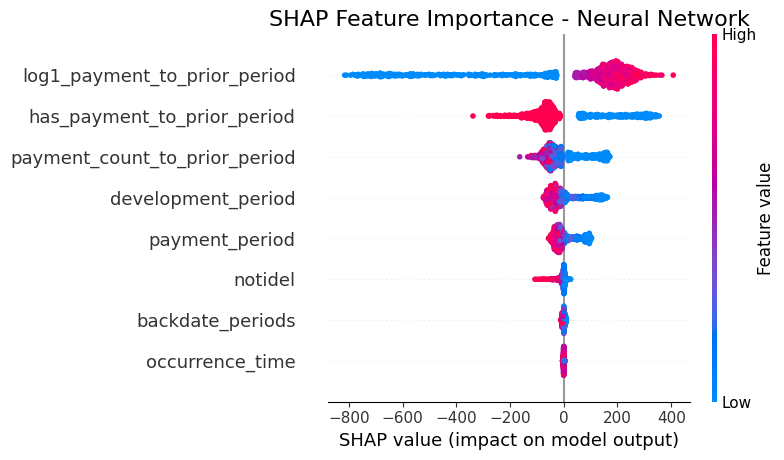

<positron-console-cell-13>:64: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


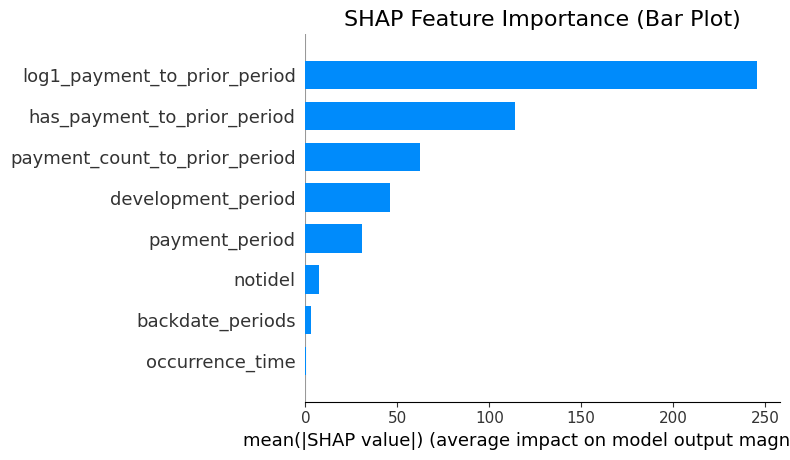

In [13]:
print("Lista features originale:", features)

try:
    feature_names = model_ffnn_detailed["keep"].features
    print("Features da ColumnKeeper:", feature_names)
except AttributeError:
    try:
        feature_names = model_ffnn_detailed["keep"].get_feature_names_out()
        print("Features da get_feature_names_out():", feature_names)
    except:
        feature_names = features 
        print("Features original list:", feature_names)

# data preparation
best_nn_model = model_ffnn_detailed["model"]
X_processed = model_ffnn_detailed["zero_to_one"].transform(
    model_ffnn_detailed["keep"].transform(nn_train)
)

if hasattr(X_processed, 'values'):
    X_processed = X_processed.values

# check on dimensions
if len(feature_names) != X_processed.shape[1]:
    print(f"Attention: {len(feature_names)} features names but {X_processed.shape[1]} columns!")
    
    feature_names = feature_names[:X_processed.shape[1]]
    print("Feature names:", feature_names)

def predict_fn(X):
    if hasattr(X, 'values'):
        X = X.values
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    return best_nn_model.predict(X)

# SHAP
explainer = shap.KernelExplainer(predict_fn, X_processed[:100])
shap_values = explainer.shap_values(X_processed[:1000])

print("=== SHAP ANALYSIS ===")
print(f"Observation Number: {len(shap_values)}")
print(f"Features Number: {len(feature_names)}")

# Feature importance 
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTOP 10 FEATURES:")
print(shap_df.head(10))

# Plot 
plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values, X_processed[:1000], 
                 feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance - Neural Network', fontsize=16)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_processed[:1000], 
                 feature_names=feature_names, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)', fontsize=16)
plt.tight_layout()
plt.show()


Generating SHAP Dependence Plots for the Top 4 Features...


<Figure size 800x600 with 0 Axes>

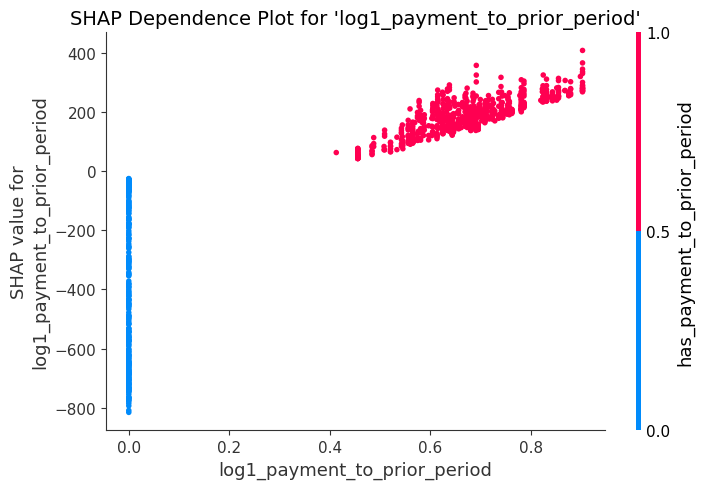

<Figure size 800x600 with 0 Axes>

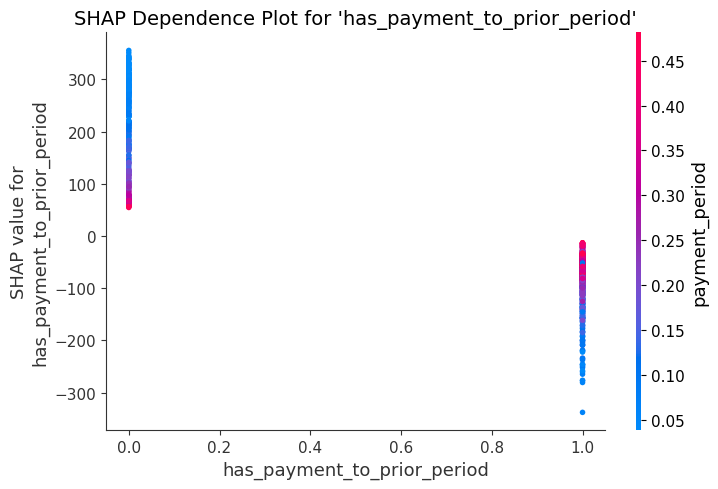

<Figure size 800x600 with 0 Axes>

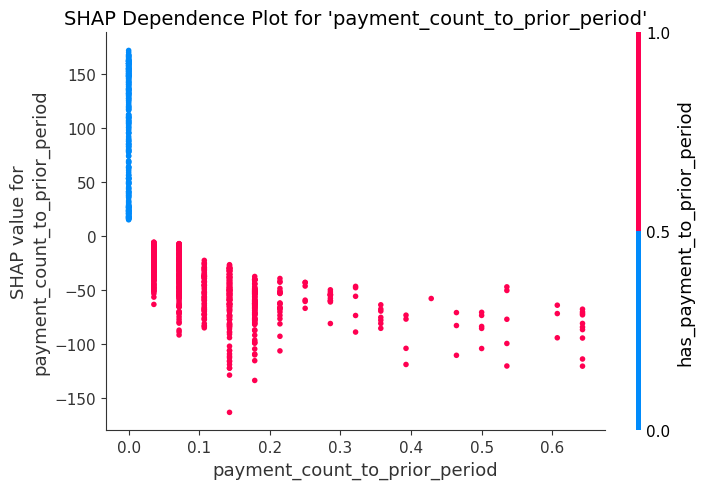

<Figure size 800x600 with 0 Axes>

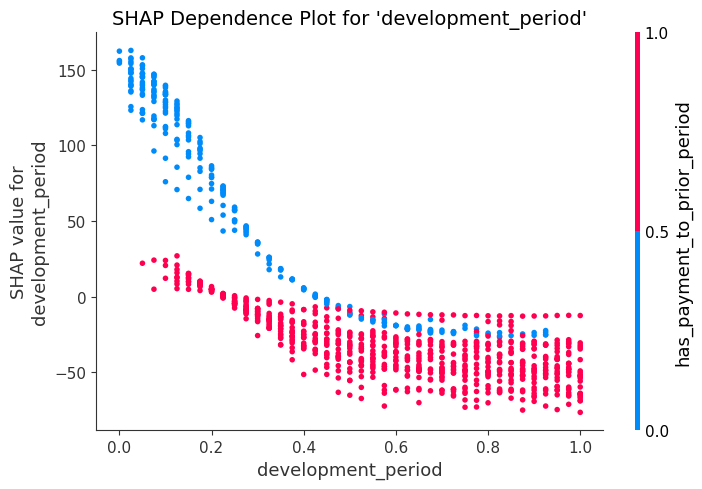


Dependence plot generation complete.


In [17]:

# --------------------------------------------------------------------------
## SHAP Dependence Plots for Important Features
# --------------------------------------------------------------------------

# Define how many top features you want to plot
N_TOP_FEATURES = 4 
top_features_df = shap_df.head(N_TOP_FEATURES)

print(f"\nGenerating SHAP Dependence Plots for the Top {N_TOP_FEATURES} Features...")

# Iterate through the top features and generate a plot for each
for i in range(N_TOP_FEATURES):
    feature_name = top_features_df.iloc[i]['feature']
    
    # Get the index of the feature name from the original feature_names list/array
    # This is necessary because shap.dependence_plot expects an index or a feature name string
    feature_idx = np.where(np.array(feature_names) == feature_name)[0][0]

    # Create the dependence plot
    plt.figure(figsize=(8, 6))
    
    # shap.dependence_plot is the correct function to use
    shap.dependence_plot(
        ind=feature_name,          # Use the feature name (or index)
        shap_values=shap_values,
        features=X_processed[:1000],
        feature_names=feature_names,
        show=False,                 # Hold showing the plot until we set the title
        # Optionally, set the 'interaction_index' to the second most important feature 
        # to color the plot, which often reveals non-linear interactions.
        interaction_index=top_features_df.iloc[1]['feature'] if N_TOP_FEATURES > 1 and i != 1 else "auto"
    )

    # Set a custom title
    plt.title(f"SHAP Dependence Plot for '{feature_name}'", fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nDependence plot generation complete.")